In [1]:
import os
import torch
import torch.nn as nn
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import urllib.request as req

## Dowanload data

In [2]:
data_url = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"

In [3]:
# create a directory

def create_dirs(dir_path):
  os.makedirs(dir_path, exist_ok=True)
  print(f"{dir_path} directory created")

ROOT_DATA_DIR = 'hymenoptera_data'
create_dirs(ROOT_DATA_DIR)

hymenoptera_data directory created


In [4]:
data_zip_file = 'data.zip'
data_zip_path = os.path.join(ROOT_DATA_DIR, data_zip_file)

if not os.path.isfile(data_zip_path):
  print('downlaoding file...')
  filename, headers = req.urlretrieve(data_url, data_zip_path)
  print(f'filename: {filename} created with info \n{headers}')
else:
  print('file is already present')

downlaoding file...
filename: hymenoptera_data/data.zip created with info 
Content-Type: application/zip
Content-Length: 47286322
Connection: close
Date: Mon, 04 Jul 2022 17:46:08 GMT
Last-Modified: Wed, 15 Mar 2017 18:46:00 GMT
ETag: "5f8c32a6554f6acb4d649776e7735e48"
x-amz-version-id: null
Accept-Ranges: bytes
Server: AmazonS3
X-Cache: Hit from cloudfront
Via: 1.1 7aea57f307e043300c172e8eaaa89c9c.cloudfront.net (CloudFront)
X-Amz-Cf-Pop: MIA3-P4
X-Amz-Cf-Id: fh8gYMjTh7dR2PHbmZDs-Aqx8Pc6oBjKk2uJFUrLAup9l-mqDBqvMA==
Age: 2926




# Unzip data

In [5]:

from zipfile import ZipFile

unzip_data_dirname = "unzip_data_dir"
unzip_data_dir = os.path.join(ROOT_DATA_DIR, unzip_data_dirname)

if not os.path.exists(unzip_data_dir):
    os.makedirs(unzip_data_dir, exist_ok=True)
    with ZipFile(data_zip_path) as f:
        f.extractall(unzip_data_dir)
else:
    print(f"data already extacted")

# Create data loaders

In [6]:
from pathlib import Path

In [7]:
train_path = Path("hymenoptera_data/unzip_data_dir/hymenoptera_data/train")
test_path = Path("hymenoptera_data/unzip_data_dir/hymenoptera_data/val")

In [8]:

img_size = (224, 224)

In [9]:
mean = torch.tensor([0.5, 0.5, 0.5])
std = torch.tensor([0.5, 0.5, 0.5])

# Transformation

In [10]:
train_transforms = transforms.Compose([
    transforms.Resize(img_size),
    transforms.RandomRotation(degrees=20),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transforms = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [11]:

train_data = datasets.ImageFolder(root=train_path, transform=train_transforms)
test_data = datasets.ImageFolder(root=test_path, transform=test_transforms)

In [12]:
train_data.class_to_idx

{'ants': 0, 'bees': 1}

In [13]:
label_map = train_data.class_to_idx
label_map

{'ants': 0, 'bees': 1}

In [14]:
train_data

Dataset ImageFolder
    Number of datapoints: 244
    Root location: hymenoptera_data/unzip_data_dir/hymenoptera_data/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=tensor([0.5000, 0.5000, 0.5000]), std=tensor([0.5000, 0.5000, 0.5000]))
           )

In [15]:
batch_size = 64
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

In [16]:
data = next(iter(train_loader))

In [17]:
len(data)

2

In [18]:
images, labels = data

In [19]:
images.shape

torch.Size([64, 3, 224, 224])

# download pretrained model

In [20]:
model = models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [21]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [22]:
def count_both_params(model):
  model_params = {'Modules': list(), 'Parameters': list()}
  total = {'trainable': 0, 'non_trainable': 0}

  for name, parameters in model.named_parameters():
    params = parameters.numel()
    if not parameters.requires_grad:
      total['non_trainable'] += params
      continue

    model_params['Modules'].append(name)
    model_params['Parameters'].append(params)
    total['trainable'] += params

  df = pd.DataFrame(model_params)
  df = df.style.set_caption(f'''Total trainable: {total['trainable']}, Non trainable: {total['non_trainable']}''')
  return df

count_both_params(model)

,Modules,Parameters
0,features.0.weight,23232
1,features.0.bias,64
2,features.3.weight,307200
3,features.3.bias,192
4,features.6.weight,663552
5,features.6.bias,384
6,features.8.weight,884736
7,features.8.bias,256
8,features.10.weight,589824
9,features.10.bias,256


In [23]:
# Freezing all the model layers

for parameters in model.parameters():
  parameters.requires_grad = False

In [24]:
count_both_params(model)

,Modules,Parameters


In [25]:
model.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [26]:
model.classifier = nn.Sequential(
    nn.Linear(in_features=9216, out_features=100, bias=True),
    nn.ReLU(),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=100, out_features=2, bias=True)
)

In [27]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, i

In [28]:
count_both_params(model)

,Modules,Parameters
0,classifier.0.weight,921600
1,classifier.0.bias,100
2,classifier.3.weight,200
3,classifier.3.bias,2


In [29]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

# Training loop

In [30]:
num_epochs = 30

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [31]:
from tqdm import tqdm
for epoch in range(num_epochs):
  with tqdm(train_loader) as tqdm_epoch:
    for images, labels in tqdm_epoch:
      tqdm_epoch.set_description(f'Epoch {epoch + 1}/{num_epochs}')

      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)
      loss = criterion(outputs, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      tqdm_epoch.set_postfix(loss=loss.item())


Epoch 30/30: 100%|██████████| 4/4 [00:08<00:00,  2.12s/it, loss=0.0055]


In [32]:
ROOT_MODEL_DIR = "trained_models"
os.makedirs(ROOT_MODEL_DIR, exist_ok=True)

MODEL_FILE = "Trans_model.pth"
MODEL_FILE_PATH = os.path.join(ROOT_MODEL_DIR, MODEL_FILE)


torch.save(model, MODEL_FILE_PATH)

# Evaluate model

In [33]:
pred = np.array([])
target = np.array([])

with torch.no_grad():
  for batch, data in enumerate(test_loader):
    image, label = data[0].to(device), data[1].to(device)

    y_pred = model(image)

    pred = np.concatenate((pred, torch.argmax(y_pred, 1).cpu().numpy()))
    target = np.concatenate((target, label.cpu().numpy()))

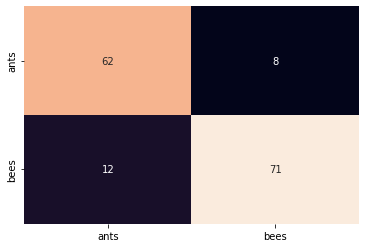

In [34]:
cm = confusion_matrix(target, pred)

# plt.figure(fi)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_map.keys(), yticklabels=label_map.keys(), cbar=False)